In [1]:
import pandas as pd
df = pd.read_csv("POP.csv")

In [2]:
df

,realtime_start,value,date,realtime_end
0,2019-12-06,156309.000,1952-01-01,2019-12-06
1,2019-12-06,156527.000,1952-02-01,2019-12-06
2,2019-12-06,156731.000,1952-03-01,2019-12-06
3,2019-12-06,156943.000,1952-04-01,2019-12-06
4,2019-12-06,157140.000,1952-05-01,2019-12-06
...,...,...,...,...
811,2019-12-06,329591.333,2019-08-01,2019-12-06
812,2019-12-06,329785.872,2019-09-01,2019-12-06
813,2019-12-06,329982.035,2019-10-01,2019-12-06
814,2019-12-06,330154.949,2019-11-01,2019-12-06


In [3]:
df['date'] = pd.to_datetime(df['date'])

In [4]:
df = df.sort_values('date').reset_index(drop=True)


In [5]:
df.set_index('date', inplace=True)

In [6]:
print("Jumlah missing value tiap kolom:\n", df.isnull().sum())

Jumlah missing value tiap kolom:
 realtime_start    0
value             0
realtime_end      0
dtype: int64


In [7]:
duplicates = df.duplicated()
print(f"Jumlah baris duplikat: {duplicates.sum()}")

Jumlah baris duplikat: 0


In [8]:
import numpy as np

In [9]:
threshold = 3
mean_val = df['value'].mean()
std_val = df['value'].std()
df['z_score'] = (df['value'] - mean_val) / std_val

In [10]:
df['outlier'] = df['z_score'].abs() > threshold
print(f"Jumlah outlier terdeteksi: {df['outlier'].sum()}")

Jumlah outlier terdeteksi: 0


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

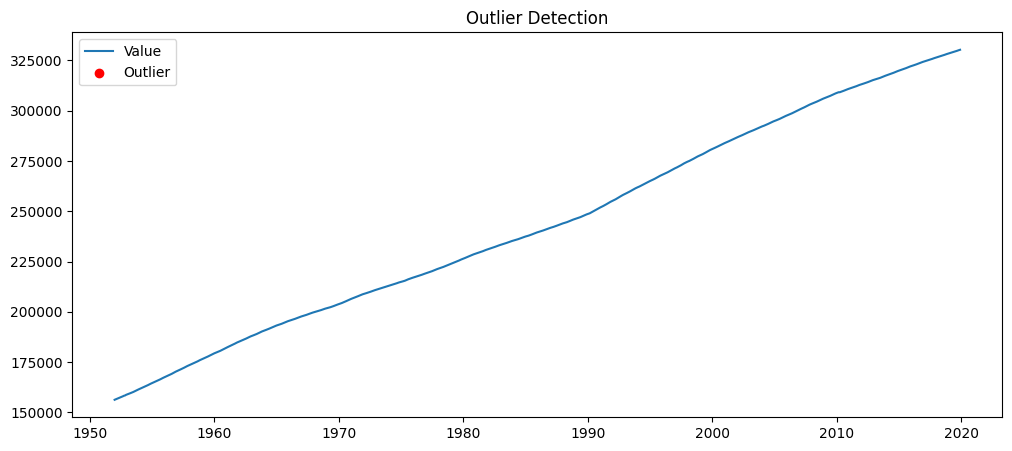

In [12]:
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['value'], label='Value')
plt.scatter(df.index[df['outlier']], df.loc[df['outlier'], 'value'], color='red', label='Outlier')
plt.title('Outlier Detection')
plt.legend()
plt.show()

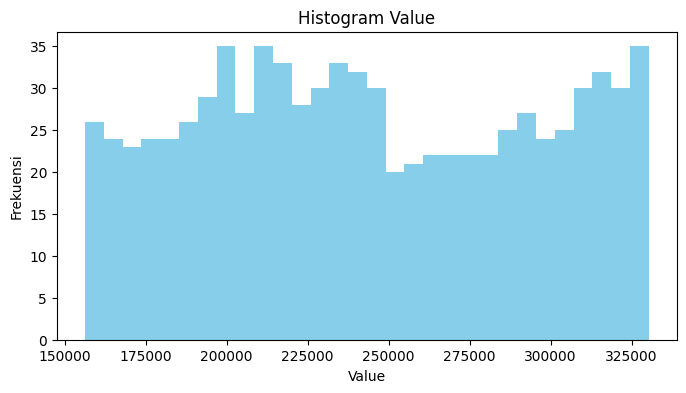

In [13]:
plt.figure(figsize=(8, 4))
plt.hist(df['value'], bins=30, color='skyblue')
plt.title('Histogram Value')
plt.xlabel('Value')
plt.ylabel('Frekuensi')
plt.show()

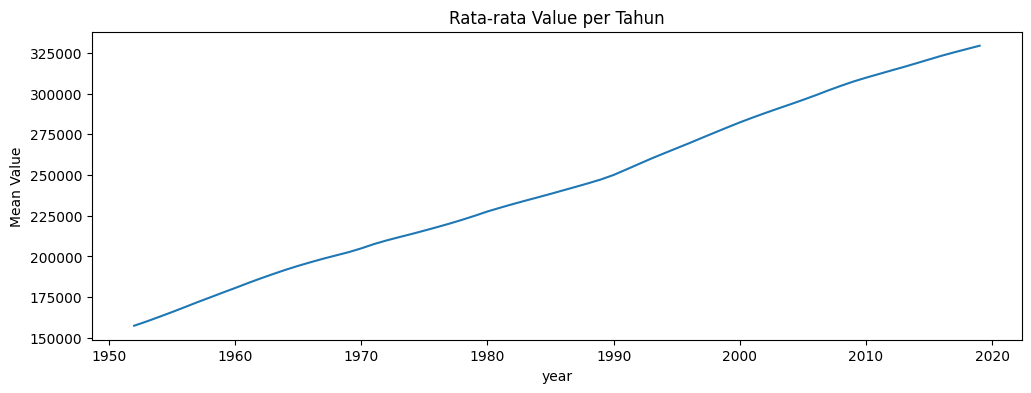

In [14]:
df['year'] = df.index.year
yearly_mean = df.groupby('year')['value'].mean()

plt.figure(figsize=(12, 4))
yearly_mean.plot()
plt.title('Rata-rata Value per Tahun')
plt.ylabel('Mean Value')
plt.show()

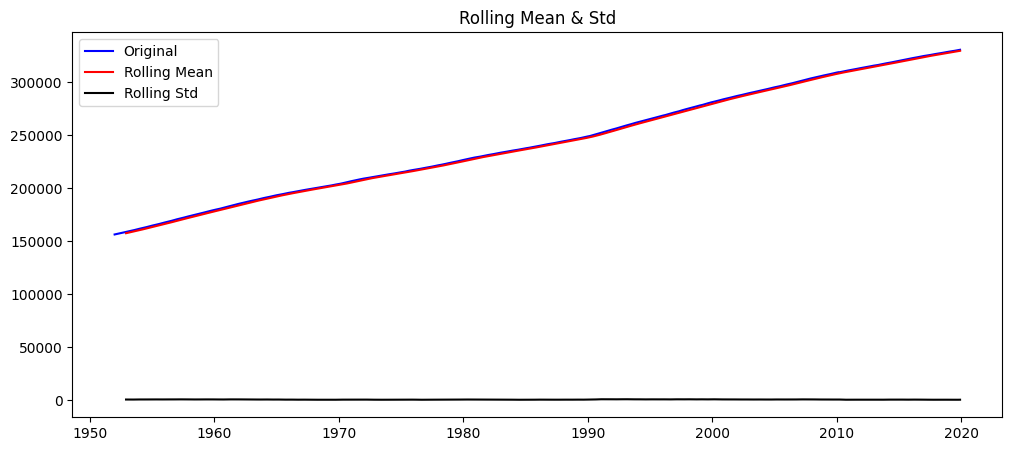

In [15]:
rolling_mean = df['value'].rolling(window=12).mean()
rolling_std = df['value'].rolling(window=12).std()

plt.figure(figsize=(12,5))
plt.plot(df['value'], color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.title('Rolling Mean & Std')
plt.legend()
plt.show()

In [16]:
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [17]:
df['log_value'] = np.log(df['value'])
df['log_diff_seasonal'] = df['log_value'].diff(12)
df['log_diff_seasonal_diff'] = df['log_diff_seasonal'].diff()

In [18]:
df_feat = df.dropna(subset=['log_diff_seasonal_diff']).copy()

In [19]:
df_feat['month'] = df_feat.index.month
df_feat['lag_1'] = df_feat['log_diff_seasonal_diff'].shift(1)
df_feat['rolling_mean_3'] = df_feat['log_diff_seasonal_diff'].shift(1).rolling(3).mean()

In [20]:
df_feat = df_feat.dropna(subset=['lag_1', 'rolling_mean_3'])

In [21]:
train = df_feat.loc[:'2018-12-01']
test = df_feat.loc['2019-01-01':]

In [22]:
target_col = 'log_diff_seasonal_diff'
exog_cols = ['month', 'lag_1', 'rolling_mean_3']

In [23]:
train_y = train[target_col]
test_y = test[target_col]

In [24]:
train_exog = train[exog_cols]
test_exog = test[exog_cols]

In [25]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

In [26]:
p = q = P = Q = range(0, 2)
d, D, s = 1, 1, 12

best_mae = np.inf
best_order = None
best_seasonal_order = None

for order in itertools.product(p, [d], q):
    for seasonal in itertools.product(P, [D], Q):
        seasonal_order = (seasonal[0], D, seasonal[1], s)
        try:
            model = SARIMAX(train_y, exog=train_exog, 
                            order=order, seasonal_order=seasonal_order,
                            enforce_stationarity=False, enforce_invertibility=False)
            result = model.fit(disp=False)
            mae = mean_absolute_error(train_y, result.fittedvalues)
            if mae < best_mae:
                best_mae = mae
                best_order = order
                best_seasonal_order = seasonal_order
        except:
            continue

print("\n✅ Best params:")
print(f" - order: {best_order}")
print(f" - seasonal_order: {best_seasonal_order}")


✅ Best params:
 - order: (1, 1, 0)
 - seasonal_order: (1, 1, 1, 12)


In [27]:
final_model = SARIMAX(train_y, exog=train_exog, 
                      order=best_order, seasonal_order=best_seasonal_order,
                      enforce_stationarity=False, enforce_invertibility=False)
final_result = final_model.fit(disp=False)



In [28]:
forecast_log_diff = final_result.forecast(steps=len(test), exog=test_exog)

In [29]:
test = test.copy()
test['forecast_log_diff'] = forecast_log_diff.values

In [30]:
history_log = list(train['log_value'][-12:])  # ambil 12 terakhir dari train
predicted_log_values = []

In [31]:
for i in range(len(test)):
    # Seasonal lag
    seasonal_lag = history_log[i] - history_log[i - 12]
    pred = test['forecast_log_diff'].iloc[i] + history_log[-1] + seasonal_lag
    predicted_log_values.append(pred)
    history_log.append(pred)  # update history

In [32]:
predicted_values = np.exp(predicted_log_values)


In [33]:
actual_values = np.exp(test['log_value'].values)


In [34]:
from sklearn.metrics import mean_squared_error, r2_score

In [35]:
mae = mean_absolute_error(actual_values, predicted_values)
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100
r2 = r2_score(actual_values, predicted_values)

print("\n📊 📍 Evaluasi Test Set (skala asli):")
print(f" - MAE  : {mae:.2f}")
print(f" - RMSE : {rmse:.2f}")
print(f" - MAPE : {mape:.2f}%")
print(f" - R²   : {r2:.4f}")

# Hasil prediksi
df_result = pd.DataFrame({
    'actual': actual_values,
    'forecast': predicted_values
}, index=test.index)
print("\n✅ Hasil prediksi (5 data teratas):")
print(df_result.head())


📊 📍 Evaluasi Test Set (skala asli):
 - MAE  : 2281.64
 - RMSE : 2804.99
 - MAPE : 0.69%
 - R²   : -21.2992

✅ Hasil prediksi (5 data teratas):
                actual       forecast
date                                 
2019-01-01  328467.812  328314.438936
2019-02-01  328610.744  328172.952216
2019-03-01  328742.843  327852.190702
2019-04-01  328890.250  327329.259424
2019-05-01  329047.319  326577.507482


In [36]:
df

,realtime_start,value,realtime_end,z_score,outlier,year,log_value,log_diff_seasonal,log_diff_seasonal_diff
date,,,,,,,,,
1952-01-01,2019-12-06,156309.000,2019-12-06,-1.732784,False,1952,11.959590,NaN,NaN
1952-02-01,2019-12-06,156527.000,2019-12-06,-1.728469,False,1952,11.960984,NaN,NaN
1952-03-01,2019-12-06,156731.000,2019-12-06,-1.724431,False,1952,11.962286,NaN,NaN
1952-04-01,2019-12-06,156943.000,2019-12-06,-1.720234,False,1952,11.963638,NaN,NaN
1952-05-01,2019-12-06,157140.000,2019-12-06,-1.716335,False,1952,11.964892,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2019-08-01,2019-12-06,329591.333,2019-12-06,1.697249,False,2019,12.705609,0.006059,-0.000004
2019-09-01,2019-12-06,329785.872,2019-12-06,1.701100,False,2019,12.706199,0.006056,-0.000004
2019-10-01,2019-12-06,329982.035,2019-12-06,1.704983,False,2019,12.706793,0.006052,-0.000004
